In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # 메모리 동적 할당
    except RuntimeError as e:
        print(e)

In [5]:
import MeCab

m = MeCab.Tagger()

out = m.parse("너 오늘 왜 이렇게 예민해?")

print(out)

너	NP,*,F,너,*,*,*,*
오늘	MAG,성분부사|시간부사,T,오늘,*,*,*,*
왜	MAG,문장부사|양상부사,F,왜,*,*,*,*
이렇게	MAG,*,F,이렇게,*,*,*,*
예민	XR,*,T,예민,*,*,*,*
해	XSA+EF,*,F,해,Inflect,XSA,EF,하/XSA/*+아/EF/*
?	SF,*,*,*,*,*,*,*
EOS



In [6]:
## 파일 로드
path = '~/aiffel/dktc/data_forder/result_kakao.csv'
data = pd.read_csv(path)

In [7]:
data.tail()

,idx,class,conversation
21945,21945,일반 대화,키키 아 야구 하고 싶어 나\n 난 레저를 정말 좋아해\n 어떤 레저 좋아하는데?\...
21946,21946,일반 대화,아 진짜? 키키\n 일할 때 어떤 때가 기분 좋아?\n 좋은 손님 만나거나 내가 일...
21947,21947,일반 대화,넌 배달 음식 자주 시켜 먹어?\n 난 굉장히 자주 시켜먹어 키키 너는?\n 오 나...
21948,21948,일반 대화,야 12월에 남친 생일인데 뭐 해줘야겠노\n 야야 아직 10월인데 벌써 걱정하냐 키...
21949,21949,일반 대화,어렸을 때 햄스터 키워 봤어요? 키키\n 오 키워봤지 키키\n 잔인한 장면을 보긴 ...


In [8]:
print('데이터 개수 :',len(data),'\n')
print('Null 개수 :',data.isnull().sum())

데이터 개수 : 21950 

Null 개수 : idx             0
class           0
conversation    0
dtype: int64


In [9]:
import MeCab
import pandas as pd
import re

# MeCab 형태소 분석기 초기화
mecab = MeCab.Tagger()

# MeCab의 parse 결과를 파싱하여 (word, pos) 튜플의 리스트로 변환하는 함수
def parse_mecab_output(text):
    parsed = mecab.parse(text)
    parsed_lines = parsed.strip().split('\n')
    tokens = []
    for line in parsed_lines:
        if line == 'EOS':
            break
        else:
            # MeCab의 출력은 "표면형\t품사 정보" 형식입니다.
            try:
                surface, feature = line.split('\t')
                # 품사 정보는 ','로 구분되어 있습니다.
                pos = feature.split(',')[0]
                tokens.append((surface, pos))
            except ValueError:
                continue  # 빈 줄이나 형식에 맞지 않는 줄은 무시
    return tokens

# 전처리 및 형태소 분석 클래스 정의
class TextPreprocessor:
    def __init__(self, pos_to_keep=None):
        # 유지할 품사 설정
        if pos_to_keep is None:
            # 주요 품사 리스트 (명사, 동사, 형용사 등)
             self.pos_to_keep = [
                'NNG',  # 일반 명사
                'NNP',  # 고유 명사
                'NNB',  # 의존 명사
                'NNBC', # 단위를 나타내는 명사
                'NR',   # 수사
                'NP',   # 대명사
                'VV',   # 동사
                'VA',   # 형용사
                'VX',   # 보조 용언
                'VCP',  # 긍정 지정사 ('이다')
                'VCN',  # 부정 지정사 ('아니다')
                'MM',   # 관형사
                'MAG',  # 일반 부사
                'MAJ',  # 접속 부사
                'XR',   # 어근
                'IC',   # 감탄사
                'JKS',  # 주격 조사
                'JKC',  # 보격 조사
                'JKG',  # 관형격 조사
                'JKO',  # 목적격 조사
                'JKB',  # 부사격 조사
                'JKV',  # 호격 조사
                'JKQ',  # 인용격 조사
                'JX',   # 보조사
                'JC',   # 접속 조사
                'EP',   # 선어말 어미
                'EF',   # 종결 어미
                'EC',   # 연결 어미
                'ETN',  # 명사형 전성 어미
                'ETM',  # 관형형 전성 어미
                'XPN',  # 체언 접두사
                'XSN',  # 명사 파생 접미사
                'XSV',  # 동사 파생 접미사
                'XSA',  # 형용사 파생 접미사
                'SN',   # 숫자
                'SL',   # 외국어
                'SH',   # 한자
                'SY',   # 기호
            ]
        else:
            self.pos_to_keep = pos_to_keep

    # 텍스트 정규화 함수
    def normalize_text(self, text):
        
        # 반복되는 문자 줄이기 (e.g., ㅋㅋㅋㅋ -> ㅋㅋ)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        # 다중 공백 제거
        text = re.sub(r'\s+', ' ', text)
        # 앞뒤 공백 제거
        text = text.strip()
        return text

    # 문장을 형태소 분석하고 필요한 품사만 추출하는 함수
    def filter_by_pos(self, sentence):
        parsed_sentence = parse_mecab_output(sentence)
        # 필요한 품사만 추출
        filtered_tokens = [word for word, pos in parsed_sentence if pos in self.pos_to_keep]
        return filtered_tokens

    # 전처리 및 토큰화 함수
    def preprocess_and_tokenize(self, sentence):
        if pd.isnull(sentence):
            return []
        # 텍스트 정규화
        sentence = self.normalize_text(sentence)
        # 형태소 분석 수행 및 필요한 품사만 추출
        tokens = self.filter_by_pos(sentence)
        return tokens

    # 데이터프레임에 전처리 및 토큰화 적용
    def apply_to_dataframe(self, df,column_name):
        df[column_name] = df['conversation'].apply(self.preprocess_and_tokenize)
        return df

In [10]:
# 품사 필터링을 적용하여 전처리 객체 생성
preprocessor = TextPreprocessor()

# 데이터프레임 로드 (df로 복사하여 진행)
df = data.copy()

df = df.iloc[:5950]

# 전처리 및 토큰화 적용
df = preprocessor.apply_to_dataframe(df,'preprocess_conversation')

# 결과 확인
df.tail()

,idx,class,conversation,preprocess_conversation
5945,5945,일반 대화,넌 여행지 고를 때 뭘 제일 중요하게 생각해?\n 저는 음... 근데 전 좀 하자는...,"[여행지, 고, 를, 때, 제일, 중요, 하, 게, 생각, \, n, 저, 는, 음..."
5946,5946,일반 대화,요새 결혼식 졸 많이 하에\n 너무 많이 한다\n 주변에서 다 간다\n 매주 결혼식...,"[요새, 결혼식, 졸, 많이, 하, 에, \, n, 너무, 많이, \, n, 주변,..."
5947,5947,일반 대화,요새는 쇼핑몰 창업도 많이 하더라\n 형도 창업 생각 있으신가요\n 아니 난 일도 ...,"[요새, 는, 쇼핑몰, 창업, 도, 많이, 하, 더라, \, n, 형, 도, 창업,..."
5948,5948,일반 대화,아 근데 진짜 어제부터 갑자기 겨울 왔어\n 비 오고 난 후로 갑자기 추워지지 않았...,"[아, 근데, 진짜, 어제, 부터, 갑자기, 겨울, 어, \, n, 비, 오, 고,..."
5949,5949,일반 대화,오늘은 어제랑 다르게 비도 안 오고 날도 완전 가을날씨네\n 글체 키키 요즘 기상청...,"[오늘, 은, 어제, 랑, 다르, 게, 비, 도, 안, 오, 고, 날, 도, 완전,..."


In [11]:
# 레이블 인코딩
label_mapping = {
    '협박 대화': 0,
    '기타 괴롭힘 대화': 1,
    '갈취 대화': 2,
    '직장 내 괴롭힘 대화': 3,
    '일반 대화' : 4
}
df['class'] = df['class'].map(label_mapping)


In [12]:
# 토크나이저 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['preprocess_conversation'])

# 시퀀스 인코딩
sequences = tokenizer.texts_to_sequences(df['preprocess_conversation'])

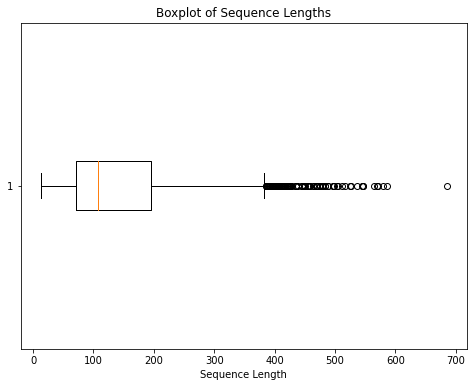

In [13]:
sequence_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 6))
plt.boxplot(sequence_lengths, vert=False)
plt.title('Boxplot of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

In [14]:
# 최대 시퀀스 길이 결정 (% 로 결정)
max_seq_len = int(np.percentile([len(seq) for seq in sequences], 99)) 

In [15]:
# 패딩 적용
X = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

# 레이블 준비
y = df['class'].values

In [16]:
# 데이터프레임에서 클래스별로 200개씩 랜덤 샘플링하여 검증 데이터 생성
df_val = df.groupby('class', group_keys=False).apply(lambda x: x.sample(200, random_state=42))

# 나머지 데이터를 학습 데이터로 사용
df_train = df.drop(df_val.index)

# 인덱스 추출
train_indices = df_train.index
val_indices = df_val.index

# 학습 및 검증 데이터 생성
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

# 03. 모델 구조 (transformer encoder = Base model)

In [17]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [18]:
# 패딩 마스크 생성 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [19]:
def scaled_dot_product_attention(q, k, v, mask):
    """ 스케일드 닷 프로덕트 어텐션 """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Q와 K의 행렬 곱

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스크가 주어졌을 경우 -inf 적용
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax를 통해 attention weights 계산
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # attention weights와 V의 행렬곱
    output = tf.matmul(attention_weights, v)

    return output

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 가중치 행렬 정의
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """ 헤드 분할: [batch_size, seq_len, d_model] -> [batch_size, num_heads, seq_len, depth] """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # 선형 변환
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # 헤드 분할
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention = scaled_dot_product_attention(q, k, v, mask)

        # 헤드 병합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 선형 변환
        output = self.dense(concat_attention)

        return output

    def get_config(self):
        # 직렬화 지원을 위한 설정 저장
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [21]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout_rate, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티 헤드 어텐션
    attention = MultiHeadAttention(d_model, num_heads)(inputs, inputs, inputs, padding_mask)
    attention = tf.keras.layers.Dropout(dropout_rate)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 네트워크
    outputs = tf.keras.layers.Dense(units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)
    outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [22]:
# 인코더 전체
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout_rate,
            maximum_position_encoding,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 및 포지셔널 인코딩
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(maximum_position_encoding, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    # 인코더 레이어 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout_rate=dropout_rate,
                                name=f"encoder_layer_{i}",
                                )(inputs=[outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 04. 모델 구조 (transformer encoder = Base model)

In [23]:
# 인코더 모델 생성
def build_encoder_model():
    inputs = tf.keras.Input(shape=(max_seq_len,), name="inputs")
    padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='padding_mask')(inputs)

    # 인코더 출력
    encoder_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate,
        maximum_position_encoding=max_seq_len,
        name="encoder"
    )(inputs=[inputs, padding_mask])

    # 글로벌 평균 풀링
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(encoder_outputs)

    # 출력 레이어 (다중 분류)
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='outputs')(pooled_output)

    # 모델 정의
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_classifier")

    return model

In [24]:
# 하이퍼파라미터 설정
vocab_size = len(tokenizer.word_index) + 1
num_layers = 2
d_model = 256
num_heads = 4
units = 512
dropout_rate = 0.4
num_classes = 5  # 클래스 수

In [25]:
# 모델 생성
model = build_encoder_model()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "transformer_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 426)]        0                                            
__________________________________________________________________________________________________
padding_mask (Lambda)           (None, 1, 1, 426)    0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5374464     inputs[0][0]                     
                                                                 padding_mask[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 256)          0           encoder[0][0

# 05. 모델 학습 (transformer encoder = Base model)

In [26]:
# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# 모델 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
155/155 [==============================] - 17s 92ms/step - loss: 0.7913 - accuracy: 0.7048 - val_loss: 0.4860 - val_accuracy: 0.8410

Epoch 00001: val_loss improved from inf to 0.48604, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 2/20
155/155 [==============================] - 14s 90ms/step - loss: 0.3444 - accuracy: 0.8780 - val_loss: 0.4825 - val_accuracy: 0.8650

Epoch 00002: val_loss improved from 0.48604 to 0.48248, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 3/20
155/155 [==============================] - 14s 91ms/step - loss: 0.2139 - accuracy: 0.9287 - val_loss: 0.7465 - val_accuracy: 0.8320

Epoch 00003: val_loss did not improve from 0.48248
Epoch 4/20
155/155 [==============================] - 14s 92ms/step - loss: 0.1372 - accuracy: 0.9517 - val_loss: 0.5513 - val_accuracy: 0.8600

Epoch 00004: val_loss did not improve from 0.48248
Epoch 5/20
155/155 [==============================] - 14s 90ms/step - loss: 0.1138 - accuracy: 0.9616 - val_loss: 0.6329 - val_accuracy: 0.8520

Epoch 00005: val_loss did not improve from 0.48248
Epoch 6/20
155/155 [==============================] - 14s 90ms/step - loss: 0.0809 - accuracy: 0.9749 - val_loss: 1.0138 - val_accuracy: 0.8210

Epoch 00006: val_loss did not improve from 0.48248
Epoch 7/20
155/155 [==============================] - 14s 90ms/step - loss: 0.0828 - accuracy: 0.9687 - val_loss: 0.9188 - val_accuracy: 0.8270

Epoch 00007: val_loss did not improve from 0.48248


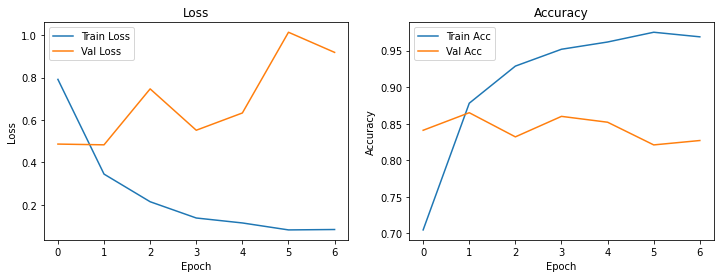

In [27]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
from sklearn.metrics import classification_report
from keras.models import load_model

# PositionalEncoding 클래스를 포함한 custom_objects 정의
custom_objects = {
    'MultiHeadAttention': MultiHeadAttention,
    'PositionalEncoding': PositionalEncoding
}

# SavedModel 형식으로 저장된 모델 불러오기
best_model = load_model('best_model', custom_objects=custom_objects)

# 검증 데이터에 대한 예측
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# 분류 보고서를 딕셔너리 형태로 얻기
report_dict = classification_report(y_val, y_pred_classes, target_names=label_mapping.keys(), output_dict=True)

# 딕셔너리를 DataFrame으로 변환
report_df = pd.DataFrame(report_dict).transpose()

# 필요한 컬럼만 선택하고 순서 지정
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]

# 소수점 자릿수 설정
report_df = report_df.round(4)

# 결과 확인
report_df

,precision,recall,f1-score,support
협박 대화,0.7960,0.800,0.7980,200.000
기타 괴롭힘 대화,0.8563,0.715,0.7793,200.000
갈취 대화,0.7828,0.865,0.8219,200.000
직장 내 괴롭힘 대화,0.8957,0.945,0.9197,200.000
일반 대화,1.0000,1.000,1.0000,200.000
accuracy,0.8650,0.865,0.8650,0.865
macro avg,0.8662,0.865,0.8638,1000.000
weighted avg,0.8662,0.865,0.8638,1000.000


In [29]:
# 1. 테스트 데이터 로드
test_data_path = '~/aiffel/dktc/data_forder/test.csv'
test_df = pd.read_csv(test_data_path)

In [30]:
# 2. 전처리 객체 생성 및 테스트 데이터 전처리
test_df['preprocess_conversation'] = test_df['text'].apply(preprocessor.preprocess_and_tokenize)
test_df['processed_text'] = test_df['preprocess_conversation'].apply(lambda tokens: ' '.join(tokens))

In [31]:
# 3. 토큰화된 테스트 데이터 생성
tokenizer.fit_on_texts(df['preprocess_conversation'])  # 훈련 데이터를 기반으로 토크나이저 적합
sequences_test = tokenizer.texts_to_sequences(test_df['processed_text'])
tokenized_test_data = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_seq_len, padding='post')

In [39]:
# 5. 모델 예측 수행
y_test_pred = best_model.predict(tokenized_test_data)


In [40]:
# 6. 예측 클래스 추출 및 threshold 적용
threshold = 0.001  # 일반 대화로 분류할 확률 기준

# 기존 예측 결과에서 가장 높은 확률을 가진 클래스를 선택
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

In [41]:
# 일반 대화의 확률이 threshold 이상인 경우 강제로 일반 대화(클래스 4)로 설정
for i in range(len(y_test_pred)):
    general_conversation_prob = y_test_pred[i, 4]  # 일반 대화 클래스(4)의 확률
    if general_conversation_prob >= threshold:
        y_test_pred_classes[i] = 4  # 일반 대화로 강제 분류

In [42]:
# 7. 예측 클래스 번호를 텍스트 레이블로 변환 (label_mapping 사용)
label_mapping = {0: '협박 대화', 1: '기타 괴롭힘 대화', 2: '갈취 대화', 3: '직장 내 괴롭힘 대화', 4: '일반 대화'}
test_df['class'] = y_test_pred_classes
test_df['class'] = test_df['class'].map(label_mapping)

In [43]:
# 8. 제출 파일 작성
submission = test_df[['idx', 'class']]
submission.columns = ['file_name', 'class']
submission.to_csv('~/aiffel/dktc/data_forder/submission.csv', index=False)

In [44]:
test_df['class'].unique()

array(['갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '협박 대화', '일반 대화'],
      dtype=object)

In [45]:
test_df['class'].value_counts()

갈취 대화          137
직장 내 괴롭힘 대화    126
기타 괴롭힘 대화      126
협박 대화          108
일반 대화            3
Name: class, dtype: int64

In [46]:
general_conversation_df = df[df['class'] == '일반 대화']

In [47]:
print(general_conversation_df)

Empty DataFrame
Columns: [idx, class, conversation, preprocess_conversation]
Index: []
